# Large-Cap Blend Fund Prediction Modelling: Random Forest Classifier

This section uses a Random Forest Classifier model to predict the probable direction of prices for the top 4 Large-Cap Blend (Blend between Large Growth & Large Value funds) ETFs by fund size (in billions - USD). As mentioned on Notebook 1, those index funds are:<br />

IVV - iShares Core S&P 500 ETF<br />
VOO - Vanguard Standard and Poor 500 ETF<br />
SPY - SPDR Standard and Poor 500 ETF Trust<br />
VTI - Vanguard Total Stock Market ETF<br />

<br />
The notebook's sections about the Prediction / Machine Learning Model are:<br />
1. Set up libraries, download historical data & visualize data<br />
2. Set up Machine Learning / M.L. target<br />
3. Train our initial model (Random Forest Classifier)<br />
4. Build a backtest system<br />
5. See results from backtest system (2nd round of predictions)<br />
6. Insert extra prediction ratio columns<br />
7. Run predictions (3rd round) using backtest again<br />
8. after adding ratios & modifying prediction function<br />
9. Statistical results - IMPORTANT<br />
10. Conclusion - IMPORTANT<br />

<br />
Morningstar fund definitions:<br /> 
1. Large Growth Funds are defined as those that invest in large-sized companies projected to grow fast. These tend to have high volatility, and high valuations (high price ratios & low dividend yields). These are known for being ‘high risk but high reward’.<br />
2. Large Value Funds are defined as those that invest in large-sized companies that have slow growth and low valuations (low price ratios and high dividend yields).<br />
3. Large Blend Funds are defined as those that invest in a combination of large Value & large Growth. These funds represent the overall U.S. Stock market and invest in across the spectrum of U.S. industries.<br />

# What is a Random Forest?

Random forests or random decision forests is a learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees - therefore the output of multiple decision trees reach a single result. Random decision forests correct for decision trees' habit of overfitting to their training set. In this case, the outcome is the probability that states how likely is for prices to increase tomorrow. 

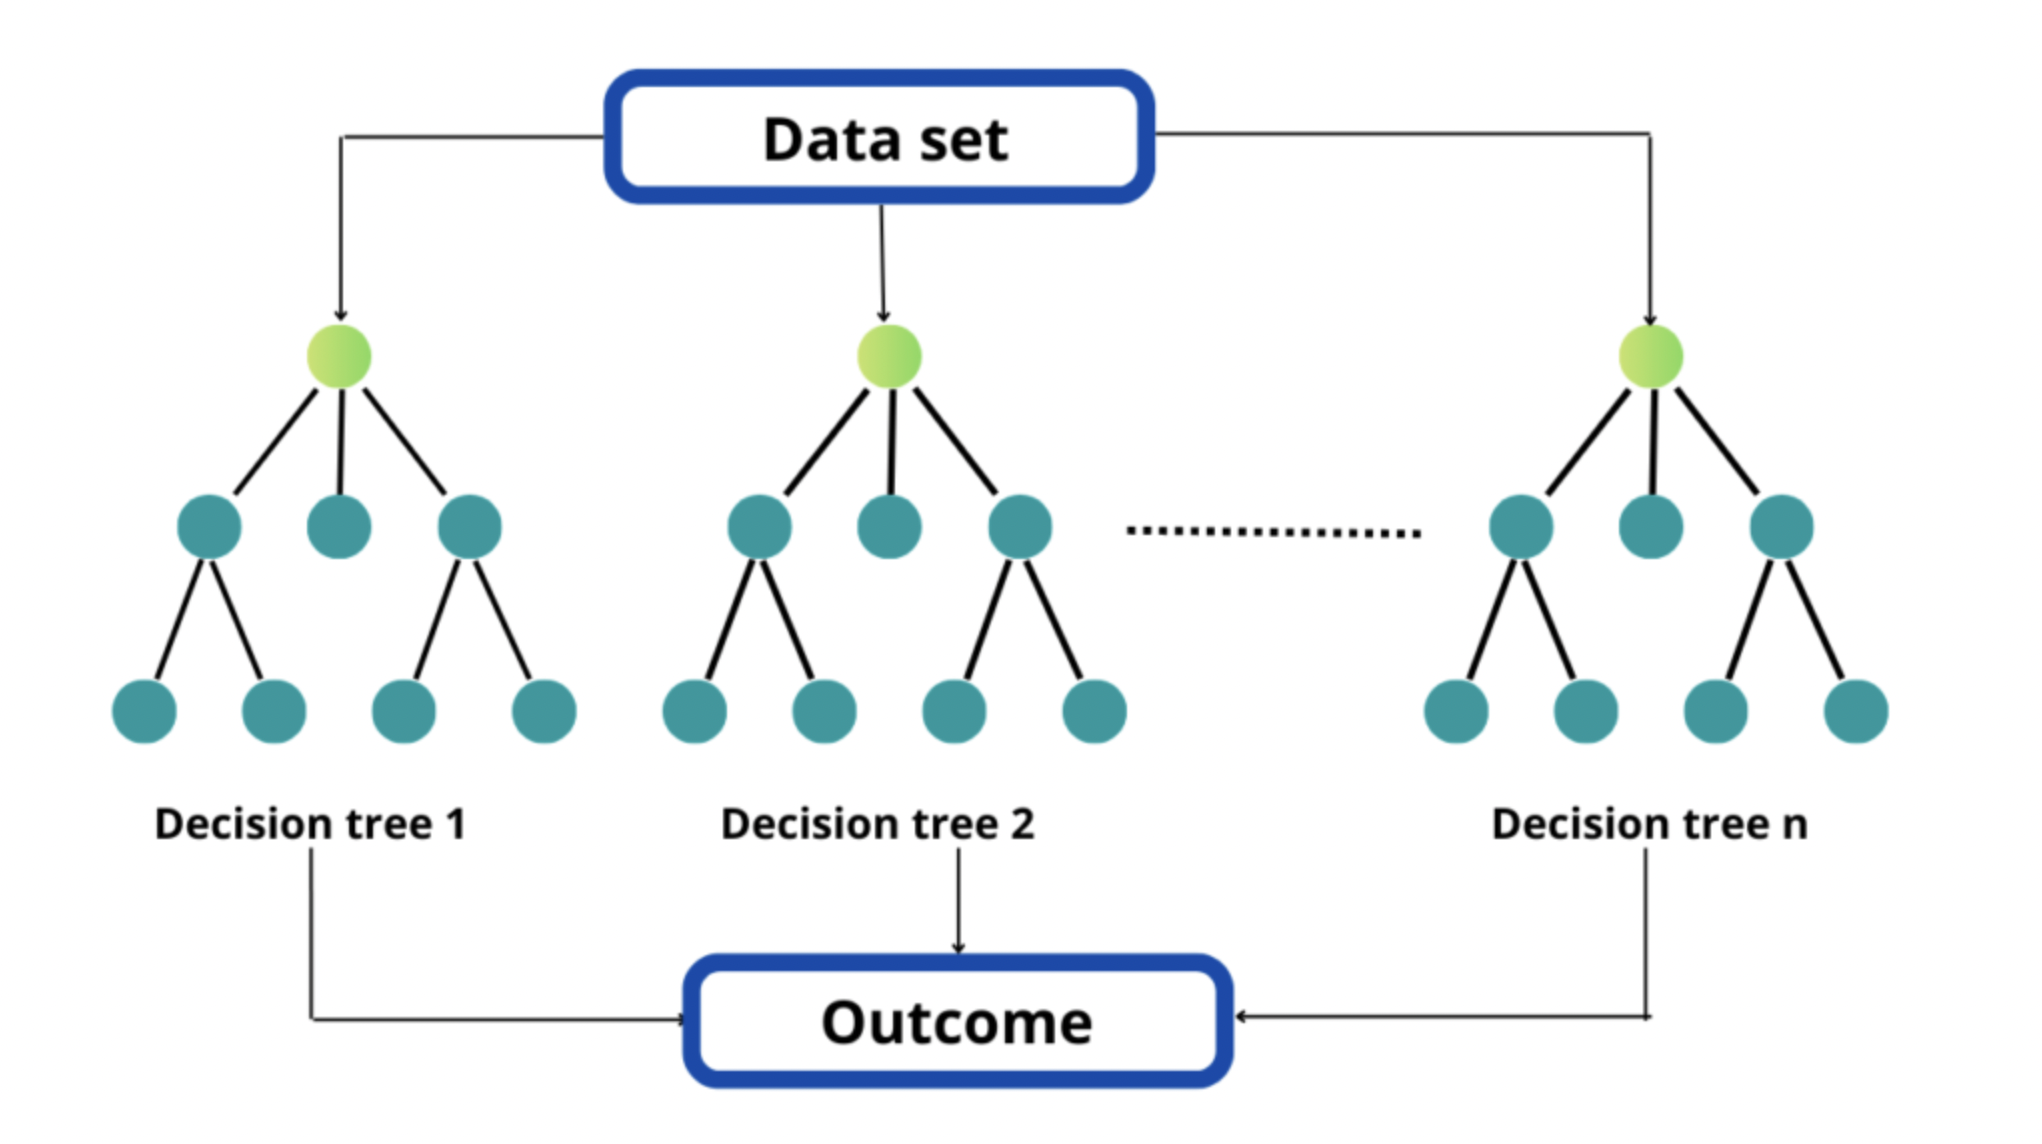

# Step 1 - Import libraries, download historical data & visualize data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

# Machine Learning Libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

In [2]:
# Get data; starting dates are the funds' inception dates
ivv = yf.download("IVV", '2000-05-15', '2023-12-30')
voo = yf.download("VOO", '2010-09-07', '2023-12-30')
spy = yf.download("SPY", '1993-01-22', '2023-12-30')
vti = yf.download("VTI", '2001-05-24', '2023-12-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Check index
ivv.index
#voo.index
#spy.index
#vti.index

DatetimeIndex(['2000-05-19', '2000-05-22', '2000-05-23', '2000-05-24',
               '2000-05-25', '2000-05-26', '2000-05-30', '2000-05-31',
               '2000-06-01', '2000-06-02',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=5941, freq=None)

### Make a plot for the 4 Large Blend ETFs

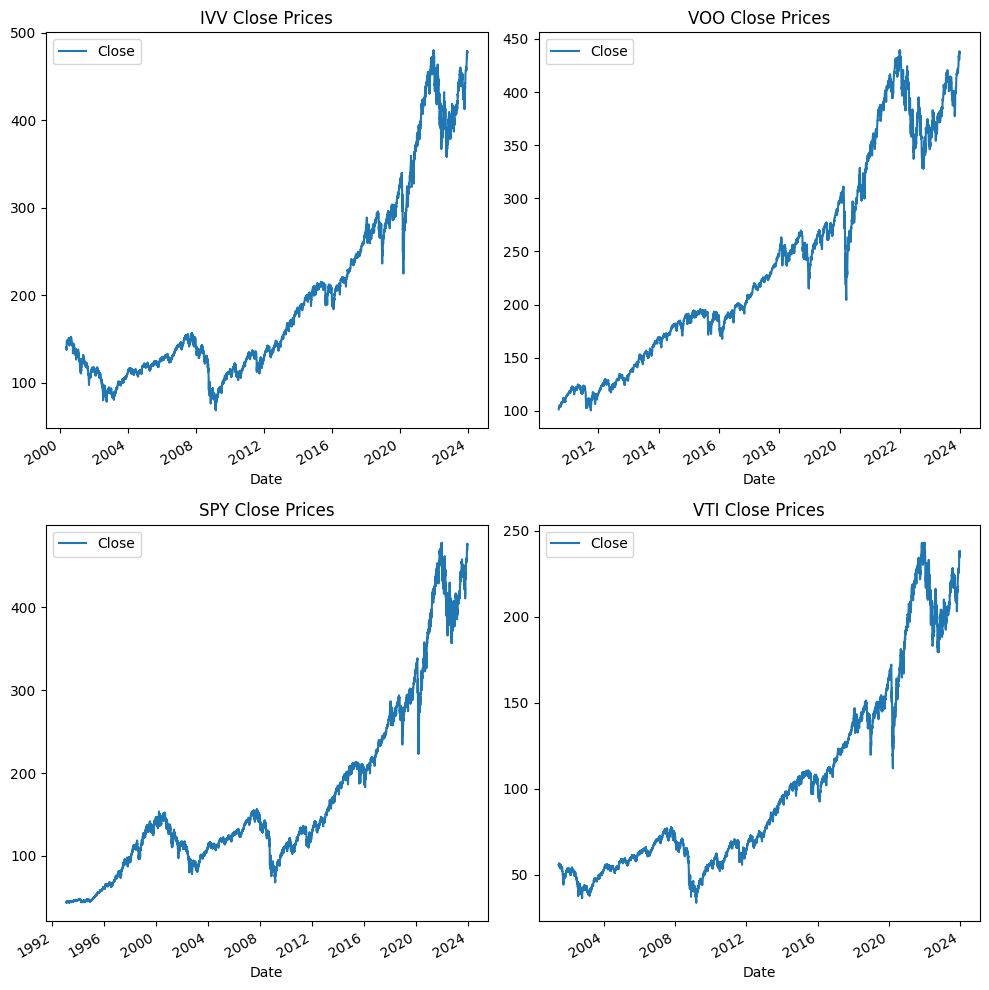

In [4]:
# Plot 4 graphs; define as y functions 
# Initialise the subplot using number of rows and columns (in this case a 4x4 subplot)
figure, axis = plt.subplots(2, 2, figsize=(10,10)) 
ivv.plot.line(y="Close", use_index=True, ax=axis[0,0]).title.set_text('IVV Close Prices')
voo.plot.line(y="Close", use_index=True, ax=axis[0,1]).title.set_text('VOO Close Prices')
spy.plot.line(y="Close", use_index=True, ax=axis[1,0]).title.set_text('SPY Close Prices')
vti.plot.line(y="Close", use_index=True, ax=axis[1,1]).title.set_text('VTI Close Prices')

figure.tight_layout();

In [5]:
# Verify that dataframes look accurate
ivv
#voo
#spy
#vti

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,91.177498,775500
2000-05-22,140.593750,140.593750,136.812500,139.812500,90.610405,1850600
2000-05-23,140.218750,140.218750,137.687500,137.687500,89.233269,373900
2000-05-24,137.750000,140.062500,136.656250,139.750000,90.569954,400300
2000-05-25,140.031250,140.937500,137.875000,138.468750,89.739548,69600
...,...,...,...,...,...,...
2023-12-22,476.130005,477.630005,473.940002,475.820007,475.820007,4266900
2023-12-26,476.320007,478.809998,476.230011,477.869995,477.869995,2235700
2023-12-27,477.779999,478.899994,477.160004,478.779999,478.779999,3761000


# Step 2 - Machine Learning (M.L.) Target

Our target is the following - will the index fund price go up or down? we are not looking for an absolute or specific future price for a particular date (as that is almost impossible to predict, what we are looking for is directionality (ideally we want prices to go up unless you are buying shares for a fund or stock) or a statistic that points out the odds of prices increasing 'tomorrow'.

In [6]:
# For 'next day' prediction we need to create a column where we shift forward 1 day of close prices 
# By shifting 1 row forward - the last will be N/A as it has nothing to get compared with.
ivv["Tomorrow"] = ivv["Close"].shift(-1)
voo["Tomorrow"] = voo["Close"].shift(-1)
spy["Tomorrow"] = spy["Close"].shift(-1)
vti["Tomorrow"] = vti["Close"].shift(-1)

In [7]:
# Display the dataframe with new column 'Tomorrow'
ivv
#voo
#spy
#vti

,Open,High,Low,Close,Adj Close,Volume,Tomorrow
Date,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,91.177498,775500,139.812500
2000-05-22,140.593750,140.593750,136.812500,139.812500,90.610405,1850600,137.687500
2000-05-23,140.218750,140.218750,137.687500,137.687500,89.233269,373900,139.750000
2000-05-24,137.750000,140.062500,136.656250,139.750000,90.569954,400300,138.468750
2000-05-25,140.031250,140.937500,137.875000,138.468750,89.739548,69600,137.843750
...,...,...,...,...,...,...,...
2023-12-22,476.130005,477.630005,473.940002,475.820007,475.820007,4266900,477.869995
2023-12-26,476.320007,478.809998,476.230011,477.869995,477.869995,2235700,478.779999
2023-12-27,477.779999,478.899994,477.160004,478.779999,478.779999,3761000,479.000000


In [8]:
# We now create a Target column with boolean output
# Outputs are 1 for 'True - prices increased the day after' & 0 for 'False - prices decreased the day after'
ivv["Target"] = (ivv["Tomorrow"] > ivv["Close"]).astype(int)
voo["Target"] = (voo["Tomorrow"] > voo["Close"]).astype(int)
spy["Target"] = (spy["Tomorrow"] > spy["Close"]).astype(int)
vti["Target"] = (vti["Tomorrow"] > vti["Close"]).astype(int)

### New columns 'Target' & 'Tomorrow' should display

In [9]:
# Display the dataframe with new column 'Target'
ivv
#voo
#spy
#vti

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target
Date,,,,,,,,
2000-05-19,142.656250,142.656250,140.250000,140.687500,91.177498,775500,139.812500,0
2000-05-22,140.593750,140.593750,136.812500,139.812500,90.610405,1850600,137.687500,0
2000-05-23,140.218750,140.218750,137.687500,137.687500,89.233269,373900,139.750000,1
2000-05-24,137.750000,140.062500,136.656250,139.750000,90.569954,400300,138.468750,0
2000-05-25,140.031250,140.937500,137.875000,138.468750,89.739548,69600,137.843750,0
...,...,...,...,...,...,...,...,...
2023-12-22,476.130005,477.630005,473.940002,475.820007,475.820007,4266900,477.869995,1
2023-12-26,476.320007,478.809998,476.230011,477.869995,477.869995,2235700,478.779999,1
2023-12-27,477.779999,478.899994,477.160004,478.779999,478.779999,3761000,479.000000,1


# Step 3 - Train initial model based on a Random Forest Classifier Algorithm

The random forest classifier is a M.L. algorithm that trains multiple decision trees with randomized parameters, and averages results from those decision trees; therefore, random forests are resistant to overfitting (term that refers to the case when a model gives a high accurate prediction for training data but not new data real world information). Note that the open price column is not linearly correlated with the target column (meaning that if open price is higher, that doesn't mean the target price will be higher).

Notice these dataframes we are training are time series data (prices that change with respect to time). The training set consists of all of the rows except the last 100. Last 100 rows go into the testing set, so that the model learns from the past without knowing anything about the future, otherwise accuracy will be high on the model but inefficient in the real world as it would 'already know about the future'. 

In [10]:
# Apply model variable to begin process
# 'n estimators' is the number of individual decision trees we want to train, the higher the n, the better the accuracy (up to a limit)
# 'min sample split' reduces overfitting
# 'random state' seed of '1' allows for running the same model multiple times, and that random numbers that are generated will be in a predictable sequence

ivv_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)
voo_model_1 = RandomForestClassifier(n_estimators = 50, min_samples_split = 50, random_state = 1)
spy_model_1 = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state = 1)
vti_model_1 = RandomForestClassifier(n_estimators = 75, min_samples_split = 75, random_state = 1)

In [11]:
def ran_basic_model(model, dataframe):
    train = dataframe.iloc[:-100] # We want to train all rows except for last 100
    test = dataframe.iloc[-100:] # We want to test only last 100 rows
    predictors = ["Close", "Volume", "Open", "High", "Low"] # We use absolute numerical data from original cols.
    model.fit(train[predictors], train["Target"]) # Training phase of predictors & boolean based Target column
    
    preds = model.predict(test[predictors]) # Run prediction on testing data - to see if training went well
    preds = pd.Series(preds, index=test.index) # Predictions are stored in a numpy array - turn to Pandas Series
    score = precision_score(test["Target"], preds)
    neg_score = 1 - score
    combined = pd.concat([test["Target"], preds], axis=1)
    combined.plot()
    msg1 = "The probability of price increment for this fund for tomorrow is: " + str(score)
    msg2 = "The probability of price decrement for this fund for tomorrow is: " + str(neg_score)
    print(msg1)
    print(msg2)

### Orange line is the prediction for the last 100 days based off training data for IVV (23 years & 7 months worth of data points), VOO (13 years & 5 months worth of data points), SPY (30 years & 11 months worth of data points), & VTI (22 years & 7 months worth of data points).

The probability of price increment for this fund for tomorrow is: 0.6176470588235294
The probability of price decrement for this fund for tomorrow is: 0.38235294117647056


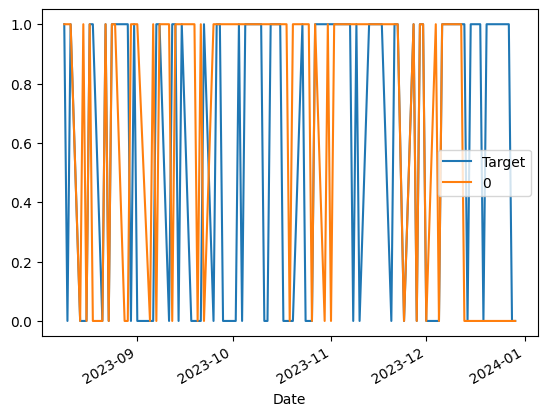

In [12]:
ivv_predictions_1 = ran_basic_model(ivv_model_1, ivv)

The probability of price increment for this fund for tomorrow is: 0.5694444444444444
The probability of price decrement for this fund for tomorrow is: 0.4305555555555556


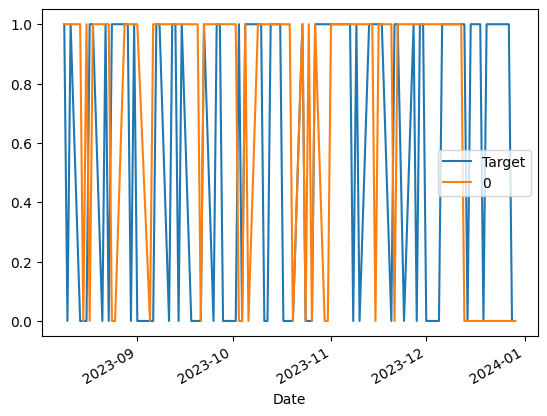

In [13]:
voo_predictions_1 = ran_basic_model(voo_model_1, voo)

The probability of price increment for this fund for tomorrow is: 0.5373134328358209
The probability of price decrement for this fund for tomorrow is: 0.4626865671641791


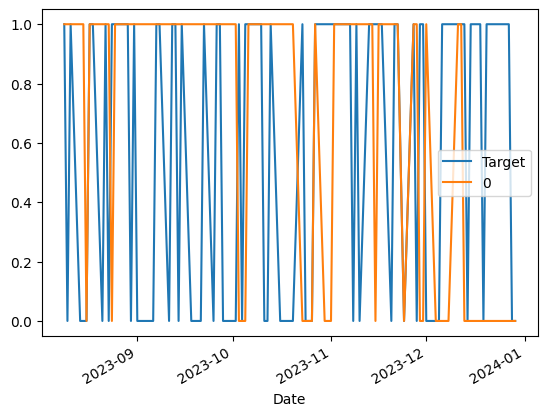

In [14]:
spy_predictions_1 = ran_basic_model(spy_model_1, spy)

The probability of price increment for this fund for tomorrow is: 0.5492957746478874
The probability of price decrement for this fund for tomorrow is: 0.45070422535211263


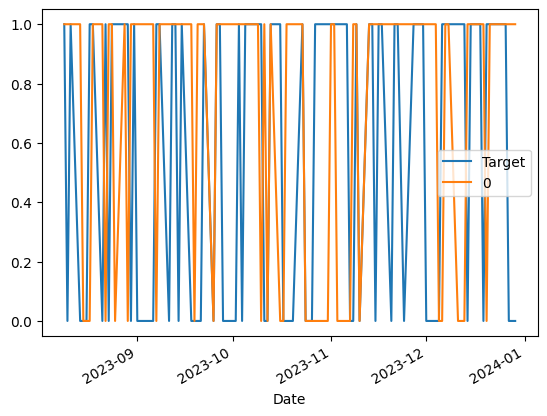

In [15]:
vti_predictions_1 = ran_basic_model(vti_model_1, vti)

# Step 4 - Building a backtest system

The goal is to compare the previous model with the backtest system. We first need to create a predictions function and then a backtest function that for every 10-year period, we'll train 1 year, then the next one, and so forth. Note that every trading year has 250 days, therefore 10 years is 2500 days.

In [16]:
# 1st step - create generic prediction function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [17]:
# 2nd step - backtest function uses previous prediction function
def backtest(dataframe, model, predictors, start=2500, step=250):
    all_predictions = [] 
    # list of dataframes, where we loop across our data year by year (except 1st 10 years) 
    # each data frame is the prediction of a single year
    for i in range(start, dataframe.shape[0], step):
        train = dataframe.iloc[0:i].copy() # training set includes all years prior to current
        test = dataframe.iloc[i:(i+step)].copy() #testing set is current year
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

# Step 5 - See results from backtest system (2nd round of predictions)

In [18]:
# Set predictors variable - array
predictors = ["Close", "Volume", "Open", "High", "Low"]

In [19]:
# Call backtest function for ivv
ivv_predictions_2 = backtest(ivv, ivv_model_1, predictors)

In [20]:
# Call backtest function for voo
voo_predictions_2 = backtest(voo, voo_model_1, predictors)

In [21]:
# Call backtest function for spy
spy_predictions_2 = backtest(spy, spy_model_1, predictors)

In [22]:
# Call backtest function for vti
vti_predictions_2 = backtest(vti, vti_model_1, predictors)

### '0' represents prediction when the prices goes down, '1' when the prices goes up

In [23]:
# We are counting IVV prediction values
ivv_predictions_2["Predictions"].value_counts()

0    2007
1    1434
Name: Predictions, dtype: int64

In [24]:
# We are counting VOO prediction values
voo_predictions_2["Predictions"].value_counts()

1    485
0    365
Name: Predictions, dtype: int64

In [25]:
# We are counting SPY prediction values
spy_predictions_2["Predictions"].value_counts()

1    3183
0    2103
Name: Predictions, dtype: int64

In [26]:
# We are counting VTI prediction values
vti_predictions_2["Predictions"].value_counts()

0    1860
1    1311
Name: Predictions, dtype: int64

### This percentage means we were x% accurate out of the entire training set. So when we say the fund's value goes 'up', it went up x% of the time

In [27]:
# IVV percentage
precision_score(ivv_predictions_2["Target"], ivv_predictions_2["Predictions"])

0.5481171548117155

In [28]:
# VOO percentage
precision_score(voo_predictions_2["Target"], voo_predictions_2["Predictions"])

0.5237113402061856

In [29]:
# SPY percentage
precision_score(spy_predictions_2["Target"], spy_predictions_2["Predictions"])

0.5372290292177191

In [30]:
# VTI percentage
precision_score(vti_predictions_2["Target"], vti_predictions_2["Predictions"])

0.5430968726163234

### Is the previous result good? The benchmark is based on how many times we predicted it would go up divided by total number of rows

In [31]:
# Benchmark for IVV
ivv_predictions_2["Target"].value_counts() / ivv_predictions_2.shape[0]

1    0.541412
0    0.458588
Name: Target, dtype: float64

In [32]:
# Benchmark for VOO
voo_predictions_2["Target"].value_counts() / voo_predictions_2.shape[0]

1    0.528235
0    0.471765
Name: Target, dtype: float64

In [33]:
# Benchmark for SPY
spy_predictions_2["Target"].value_counts() / spy_predictions_2.shape[0]

1    0.545025
0    0.454975
Name: Target, dtype: float64

In [34]:
# Benchmark for VTI
vti_predictions_2["Target"].value_counts() / vti_predictions_2.shape[0]

1    0.543046
0    0.456954
Name: Target, dtype: float64

# Step 6 - Insert extra prediction ratio columns

In [35]:
# re-write predict function
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1] #this returns a probability that row will be 0 or 1
    preds[preds >=.6] = 1 #change threshold to 60% - if greater than or equal to .6 then return 1
    preds[preds <.6] = 0 #change threshold to 60% - if less than .6 then return 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [36]:
# Add ratio columns to dataframes or datasets
# 'horizons' refer to the last 4 yrs, last year, last 3 month, last 5 days, last 2 days
horizons = [2, 5, 60, 250, 1000] 
ivv_new_predictors = []
spy_new_predictors = []
vti_new_predictors = []

ivv_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)
spy_model_init = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
vti_model_init = RandomForestClassifier(n_estimators=150, min_samples_split=38, random_state=1)

for horizon in horizons:
    ivv_rolling_averages = ivv.rolling(horizon).mean()
    spy_rolling_averages = spy.rolling(horizon).mean()
    vti_rolling_averages = vti.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    ivv[ratio_column] = ivv["Close"] / ivv_rolling_averages["Close"]
    spy[ratio_column] = spy["Close"] / spy_rolling_averages["Close"]
    vti[ratio_column] = vti["Close"] / vti_rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    ivv[trend_column] = ivv.shift(1).rolling(horizon).sum()["Target"]
    spy[trend_column] = spy.shift(1).rolling(horizon).sum()["Target"]
    vti[trend_column] = vti.shift(1).rolling(horizon).sum()["Target"]

    ivv_new_predictors += [ratio_column, trend_column]
    spy_new_predictors += [ratio_column, trend_column]
    vti_new_predictors += [ratio_column, trend_column]

In [39]:
# 'v_horizons' refer to the last last year, last 3 month, last 5 days, last 2 days - for voo
# This block code was designed for VOO's prediction as it contains less data - doing a 4-yr loop leads to an error
v_horizons = [2, 5, 60, 250] 
voo_new_predictors = []

voo_model_init = RandomForestClassifier(n_estimators=100, min_samples_split=25, random_state=1)

for horizon in v_horizons:
    voo_rolling_averages = voo.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    voo[ratio_column] = voo["Close"] / voo_rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    voo[trend_column] = voo.shift(1).rolling(horizon).sum()["Target"]

    voo_new_predictors += [ratio_column, trend_column]

In [40]:
ivv = ivv.dropna(subset = ivv.columns[ivv.columns != "Tomorrow"])
voo = voo.dropna(subset = voo.columns[voo.columns != "Tomorrow"])
spy = spy.dropna(subset = spy.columns[spy.columns != "Tomorrow"])
vti = vti.dropna(subset = vti.columns[vti.columns != "Tomorrow"])

In [46]:
# Verify new dataframes have no errors
#ivv #4941 rows
voo # < 4000 rows #NOTE that VOO is not old enough for this test - hence it's horizon only expands until 1yr 
#spy #6784 rows
#vti #4176 rows

,Open,High,Low,Close,Adj Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250
Date,,,,,,,,,,,,,,,,
2011-09-06,104.720001,107.139999,104.639999,107.000000,84.778236,197950,110.019997,1,0.996554,0.0,0.976028,2.0,0.930864,31.0,0.926478,137.0
2011-09-07,108.720001,110.040001,108.300003,110.019997,87.171051,199700,108.860001,0,1.013916,1.0,1.005594,2.0,0.958067,31.0,0.952356,137.0
2011-09-08,109.339996,110.580002,108.680000,108.860001,86.251915,115650,106.000000,0,0.994700,1.0,1.000147,1.0,0.949256,30.0,0.942125,136.0
2011-09-09,107.660004,107.940002,105.440002,106.000000,83.985931,174200,106.760002,1,0.986689,0.0,0.982173,1.0,0.925683,30.0,0.917279,136.0
2011-09-12,104.699997,106.760002,104.360001,106.760002,84.588058,161350,107.639999,1,1.003572,1.0,0.991014,2.0,0.933628,30.0,0.923746,136.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,435.459991,436.839996,433.480011,435.290009,435.290009,4035200,437.100006,1,1.001162,2.0,1.001408,4.0,1.068856,37.0,1.112030,139.0
2023-12-26,435.670013,437.920013,435.579987,437.100006,437.100006,3835800,437.899994,1,1.002075,2.0,1.004851,4.0,1.071353,38.0,1.115666,140.0
2023-12-27,436.899994,438.019989,436.420013,437.899994,437.899994,4271000,437.970001,1,1.000914,2.0,1.006824,4.0,1.071335,39.0,1.116662,141.0


# Step 7 - Run predictions (3rd round) after adding ratios & modifying prediction function

In [47]:
# Apply backtest function for IVV
ivv_predictions_3 = backtest(ivv, ivv_model_init, ivv_new_predictors)

In [48]:
# Apply backtest function for SPY
spy_predictions_3 = backtest(spy, spy_model_init, spy_new_predictors)

In [49]:
# # Apply backtest function for VOO
voo_predictions_3 = backtest(voo, voo_model_init, voo_new_predictors)

In [50]:
# Apply backtest function for VTI
vti_predictions_3 = backtest(vti, vti_model_init, vti_new_predictors)

### Prediction percentages - IVV (Precision Score & Benchmark %)

In [51]:
ivv_predictions_3["Predictions"].value_counts()

0.0    2082
1.0     359
Name: Predictions, dtype: int64

In [52]:
# Precision score %
precision_score(ivv_predictions_3["Target"], ivv_predictions_3["Predictions"])

0.5153203342618384

In [53]:
# Benchmark %
ivv_predictions_3["Target"].value_counts() / ivv_predictions_3.shape[0]

1    0.538304
0    0.461696
Name: Target, dtype: float64

### Prediction percentages - VOO (Precision Score & Benchmark %)

In [54]:
voo_predictions_3["Predictions"].value_counts()

0.0    499
1.0    101
Name: Predictions, dtype: int64

In [55]:
# Precision score %
precision_score(voo_predictions_3["Target"], voo_predictions_3["Predictions"])

0.46534653465346537

In [56]:
# Benchmark %
voo_predictions_3["Target"].value_counts() / voo_predictions_3.shape[0]

1    0.511667
0    0.488333
Name: Target, dtype: float64

### Prediction percentages - SPY (Precision Score & Benchmark %)

In [57]:
spy_predictions_3["Predictions"].value_counts()

0.0    3716
1.0     570
Name: Predictions, dtype: int64

In [58]:
# Precision score %
precision_score(spy_predictions_3["Target"], spy_predictions_3["Predictions"])

0.5368421052631579

In [59]:
# Benchmark %
spy_predictions_3["Target"].value_counts() / spy_predictions_3.shape[0]

1    0.54293
0    0.45707
Name: Target, dtype: float64

### Prediction percentages - VTI (Precision Score & Benchmark %)

In [60]:
vti_predictions_3["Predictions"].value_counts()

0.0    1784
1.0     387
Name: Predictions, dtype: int64

In [61]:
# Precision score %
precision_score(vti_predictions_3["Target"], vti_predictions_3["Predictions"])

0.5116279069767442

In [62]:
# Benchmark %
vti_predictions_3["Target"].value_counts() / vti_predictions_3.shape[0]

1    0.539383
0    0.460617
Name: Target, dtype: float64

# Step 9 - Results

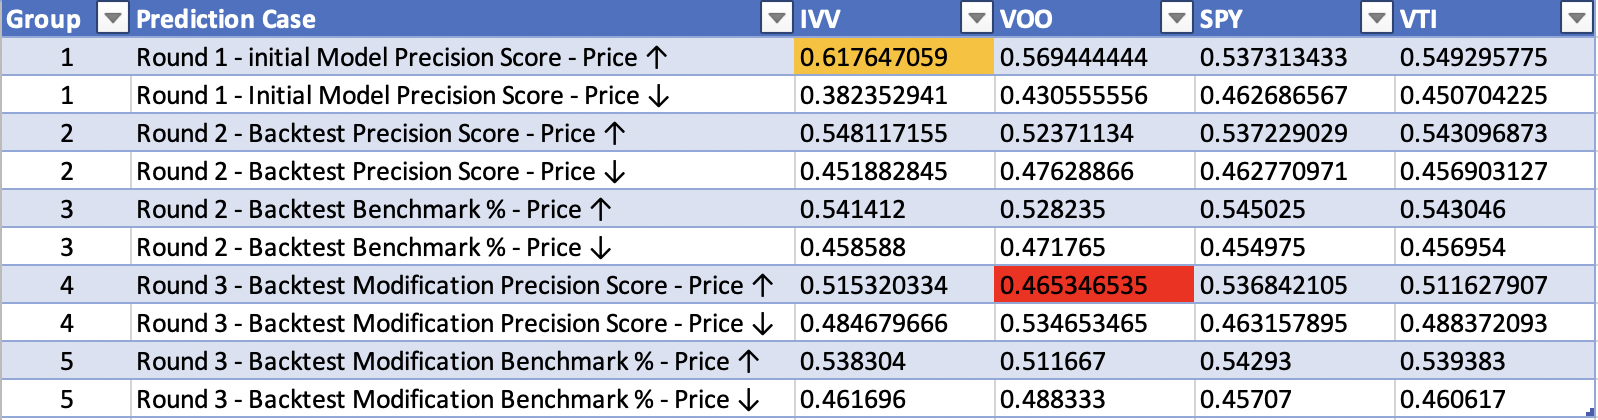

# Step 10 - Conclusion

The random forest decision classifier / machine learning model was trained efficiently as it accurately predicted the odds of share price (from any of the top 4 large blend funds - IVV, VOO, SPY, VTI) increment in the future or 'tomorrow'. It is reasonable to have a probability ranging between 50% & 60%, as realistically nobody can predict future prices for certain but we are aware (as seen in the financial analysis' Moving Averages graphs - Jupyter Notebooks 1 through 3) that Index Funds tend to increase in value with respect to time despite economic downturns or outlying events (such COVID Pandemic). The highlighted cells (orange & red) represent the percentages that were off - orange being slightly inaccurate & red being incorrect. The reason why VOO's round 3 precision score was off was due to the lack of historical data, unlike the rest of the funds which are older or contain a greater number of data points. In addition, red was selected as higher inaccuracy is expected on the 1st round but not on the 3rd round after improving the backtest system.